## Importing Libraries 

In [1]:
%matplotlib notebook
#importing Libraries
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import nltk
nltk.download('punkt')
from nltk import ngrams
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize 
import string
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
from nltk import ngrams

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
papers = pd.read_excel('modifiedPapers.xlsx')
papers = papers.iloc[:,1:]
papers.head()

,ID,Year,Topic Groups,Topics,Title,Authors,Keywords,Abstract,Month,NewYears,Type
0,AAAI-13-1,2013,Multiagent Systems,Auctions and Market-Based Systems\nE-Commerce\...,The cascade auction – a mechanism for deterrin...,"U Feige, G Kalai, M Tennenholz",Mediators\nAuctions\nCollusion\nAd Exchanges,We introduce a sealed bid auction of a single ...,5,2011,short paper
1,AAAI-13-2,2013,Machine Learning\nReasoning,Dimension Reduction/Feature Selection\nOnline ...,Basis Adaptation for Sparse Nonlinear Reinforc...,"S Mahadevan, S Giguere, N Jacek",Reinforcement learning\nSparsity\nMirror desce...,This paper presents a new approach to basis ad...,2,2015,case report
2,AAAI-13-3,2013,Multiagent Systems,Coordination and Collaboration\nGame Theory,Optimal Coalition Structures in Cooperative Gr...,"Y Bachrach, P Kohli, V Kolmogorov",Cooperative Game Theory\nCoalition Structure G...,Representation languages for coalitional game...,10,2014,white paper
3,AAAI-13-4,2013,Optimization,Heuristic Search\nEvaluation and Analysis\nSearch,External Memory Best-First Search for Multiple...,"M Hatem, W Ruml",External-Memory Search\nParallel Search\nMulti...,Multiple sequence alignment (MSA) is a central...,1,2014,case report
4,AAAI-13-5,2013,Multiagent Systems,Auctions and Market-Based Systems\nE-Commerce\...,Posted Prices Exchange for Display Advertising...,"Y Engel, M Tennenholtz",Display Advertising\nDynamic Pricing\nMarket E...,We propose a new market design for display adv...,3,2014,book chapter


**For Authors blank we'll fill it with <'Unknown'>**

In [3]:
papers.loc[papers['Authors'].isna(),'Authors'] = '<Unknown>'

In [265]:
from operator import itemgetter

Authors = {}

for i in range(0, len(papers)):
    for author in papers.iloc[i,5].split(', '):
        if author in Authors:
            Authors[author]+=1
        else:
            Authors[author]=1

sorted_Authors = sorted(Authors.items(), key=itemgetter(1), reverse=True)

## Defining functions to add nodes and edges

In [5]:
def add_nodes(G, df, col, type_name, color):
    """Add entities to G from the 'col' column of the 'df' DataFrame. The new nodes are annotated with 'type_name' label."""
    nodes = list(df[~df[col].isnull()][col].unique())
    G.add_nodes_from([(n,dict(type=type_name)) for n in nodes],node_color=color)
    print("Nodes (%s,%s) were added" % (col, type_name))

In [6]:
def add_links(G, df, col1, col2, type_name, color):
    """Add links to G from the 'df' DataFrame. The new edges are annotated with 'type_name' label."""
    df_tmp = df[(~df[col1].isnull()) & (~df[col2].isnull())]
    links = list(zip(df_tmp[col1],df_tmp[col2]))
    G.add_edges_from([(src, trg, dict(type=type_name)) for src, trg in links], edge_color=color)
    print("Edges (%s->%s,%s) were added" % (col1, col2, type_name))

**Creating a directional graph**

In [7]:
G = nx.DiGraph()

In [8]:
add_nodes(G, papers, "ID", "PaperId",'#59aee3')
add_nodes(G, papers, "Year", "Year", "#e0e058")
add_links(G, papers, "ID", "Year", "YEAR_PUBLISHED", "#a6a6a4")
add_nodes(G, papers, "Month", "Month", "#f2dc33")
add_nodes(G, papers, "NewYears", "NewYears", "#e7ed3b")
add_nodes(G, papers, "Type", "Type", "#ccccc8")
add_links(G, papers, "ID", "Month", "PUBLISHED_IN_MONTH", "#a6a6a4")
add_links(G, papers, "ID", "NewYears", "ALSO_PUBLISHED_IN", "#a6a6a4")
add_links(G, papers, "ID", "Type", "OF_FORMAT", "#a6a6a4")

Nodes (ID,PaperId) were added


**Creating functions for adding multilevel columns**

In [13]:
import itertools

def add_nodes_multielements(G, df, col, type_name, color):
    """Add entities to G from the 'col' column of the 'df' DataFrame. The new nodes are annotated with 'type_name' label."""
    nodes_ListofList = []
    elements = df[col].str.split("\n")
    for i in range(0,len(elements)):
        nodes_ListofList.append(elements[i])
    nodes = list(itertools.chain.from_iterable(nodes_ListofList))
    nodes = list(dict.fromkeys(nodes))
    G.add_nodes_from([(str(n.lower()+" : "+col),dict(type=type_name)) for n in nodes], node_color=color)
    print("Nodes (%s,%s) were added" % (col, type_name))

In [14]:
def add_links_multielement(G, df, col1, col2, type_name, color):
    for i in range(0, len(df)):
        for token in [n for n,v in G.nodes(data=True) if v['type'] == col2]:
            tokenWord = token.split(" : ")[0]
            if tokenWord in df[col2][i].lower():
                G.add_edges_from([(df[col1][i], token, dict(type=type_name))], edge_color=color)
    print("Edges (%s->%s,%s) were added" % (col1, col2, type_name))

In [15]:
add_nodes_multielements(G, papers, 'Topic Groups', 'Topic Groups',"#de2a2a")

Nodes (Topic Groups,Topic Groups) were added


In [16]:
add_links_multielement(G, papers, 'ID', 'Topic Groups', 'BELONGS_TO_TOPIC_GROUP', "#a6a6a4")

Edges (ID->Topic Groups,BELONGS_TO_TOPIC_GROUP) were added


In [17]:
add_nodes_multielements(G, papers, 'Topics', 'Topics','#bb8be8')

Nodes (Topics,Topics) were added


In [18]:
add_links_multielement(G, papers, 'ID', 'Topics', 'HAS_TOPICS', "#a6a6a4")

Edges (ID->Topics,HAS_TOPICS) were added


In [19]:
add_nodes_multielements(G, papers, 'Keywords','Keywords','#e39a42')

Nodes (Keywords,Keywords) were added


In [20]:
add_links_multielement(G, papers, 'ID', 'Keywords', 'HAS_KEYWORDS', "#a6a6a4")

Edges (ID->Keywords,HAS_KEYWORDS) were added


In [21]:
G.remove_node(' : Topics')

**Defining functions for adding gramns from title**

In [22]:
def get_text_grams(df,col, ID, n):
    'Select the n (ngrams) of the text after preprocessing by lowering case, removing stop words and plurals'
    sentence = df[df['ID']==ID][col].values[0]
    # Tokenize sentence
    tokens = word_tokenize(sentence)
    # Remove capital letters
    tokens = [w.lower() for w in tokens]
    # Remove puntucation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words and prular
    Lem = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = [Lem.lemmatize(w) for w in words if not w in stop_words]   
    if n == 1:
        return(words)
    else:
        #Get n grams
        if n > len(words):
            n = len(words)
        textclean = " ".join(words)
        twograms = ngrams(textclean.split(), n)
        test = []
        for grams in twograms:
            test.append(" ".join(grams))
        return(test)

In [23]:
def fromText_toID(G, df, col, n_gram, node_color, edge_color, node_type_name, edge_type_name):
    "Create entities based on the n (ngrams) of the text (title) and links them to the paper id"
    SelectedNodes = [nodeId for nodeId, label in G.nodes(data=True) if label['type'] == 'PaperId']
    for nodeId in SelectedNodes:
        nodes = list(dict.fromkeys(get_text_grams(df, col, nodeId, n_gram)))
        G.add_nodes_from([(str(n+' : '+col),dict(type=node_type_name)) for n in nodes], node_color=node_color)
        G.add_edges_from([(str(n+' : '+col), nodeId, dict(type=edge_type_name)) for n in nodes], edge_color=edge_color)
    print("Nodes ",(node_type_name),"were added, Edges (ID->",node_type_name,",",edge_type_name,") were aded")

In [24]:
fromText_toID(G, papers, 'Title', 1, "#e34242", "#a6a6a4", 'TitleWords', 'HAS_WORDS_IN_TITLE')

Nodes  TitleWords were added, Edges (ID-> TitleWords , HAS_WORDS_IN_TITLE ) were aded


In [25]:
fromText_toID(G, papers, 'Title', 2, "#e34242", "#a6a6a4", 'Title2Grams', 'HAS_WORDS_IN_TITLE')

Nodes  Title2Grams were added, Edges (ID-> Title2Grams , HAS_WORDS_IN_TITLE ) were aded


**Adding Authors, Title and Abstract as attributes of the Paper nodes**

In [26]:
for n,v in G.nodes(data=True):
    if v['type'] == 'PaperId':
        G.nodes[n]['Authors'] = papers.loc[papers['ID']==n,'Authors'].values[0]
        G.nodes[n]['Title'] = papers.loc[papers['ID']==n,'Title'].values[0]
        G.nodes[n]['Abstract'] = papers.loc[papers['ID']==n,'Abstract'].values[0]

In [266]:
G.node['AAAI-13-1']

{'node_color': '#59aee3',
 'type': 'PaperId',
 'Authors': 'U Feige, G Kalai, M Tennenholz',
 'Title': 'The cascade auction – a mechanism for deterring collusion in auctions',
 'Abstract': 'We introduce a sealed bid auction of a single item in which\nthe winner is chosen at random among the highest k bidders\naccording to a fixed probability distribution, and the price for\nthe chosen winner is the Vickrey-Clarke-Groves price. We\ncall such an auction a cascade auction. Our analysis suggests\nthat this type of auction may give higher revenues compared\nto second price auction in cases of collusion.',
 'degree': 3}

**Adding Authors Nodes and Linking to Papers ID**

In [27]:
SelectedNodes = [nodeId for nodeId, label in G.nodes(data=True) if label['type'] == 'PaperId']
for nodeId in SelectedNodes:
    nodes = list(itertools.chain(*[n.split(', ') for n in papers.loc[papers['ID']==nodeId,'Authors'].values]))
    G.add_nodes_from([(n,dict(type='Authors')) for n in nodes], node_color='#02f506')
    G.add_edges_from([(n, nodeId, dict(type='WROTE_PAPER')) for n in nodes], edge_color='#a6a6a4')
print("Nodes ",('Authors'),"were added, Edges (ID->",'Authors',",",'WROTE_PAPER',") were aded")

Nodes  Authors were added, Edges (ID-> Authors , WROTE_PAPER ) were aded


**Adding Authors Colaboration Links**

In [28]:
SelectedNodes = [nodeId for nodeId, label in G.nodes(data=True) if label['type'] == 'PaperId']
for nodeId in SelectedNodes:
    links = list(itertools.permutations([n for n in G.predecessors(nodeId) if G.node[n]['type']=='Authors'],2))
    G.add_edges_from([(src, trg, dict(type='COLABORATED_WITH')) for src, trg in links], edge_color='#a6a6a4')
print("Edges (%s->%s,%s) were added" % ('Author', 'Author', 'COLABORATED_WITH'))    

Edges (Author->Author,COLABORATED_WITH) were added


**Filtering Keywords, Topic Group and PaperId nodes**

In [29]:
keywords = [n.split(' : ')[0] for n,v in G.nodes(data=True) if v['type'] == 'Keywords']
Topic_Groups = [n.split(' : ')[0] for n,v in G.nodes(data=True) if v['type'] == 'Topic Groups']
PapersId =  [n for n,v in G.nodes(data=True) if v['type'] == 'PaperId']
Topics = [n.split(' : ') for n,v in G.nodes(data=True) if v['type'] == 'Topics']
Authors = [n for n,v in G.nodes(data=True) if v['type'] == 'Authors']

**Connecting Topics to Keywords and Topic Group to topic**

In [30]:
import re

for paper in PapersId:
    node_Keywords = []
    node_Topics = []
    node_TopicGroup =[]
    for s,t in G.out_edges(paper):
        if re.search(".*: Keywords", str(t)):
            node_Keywords.append(t)
        if re.search(".*: Topics", str(t)):
            node_Topics.append(t)
        if re.search(".*: Topic Groups", str(t)):
            node_TopicGroup.append(t)
    for tg in node_TopicGroup:
        for t in node_Topics:
            for k in node_Keywords:
                G.add_edges_from([(t,k, dict(type='HAS_KEYWORD'))], edge_color= "#a6a6a4")
        G.add_edges_from([(tg, t, dict(type='HAS_TOPICS'))], edge_color= "#a6a6a4")

**Saving graph**

In [31]:
nx.write_gexf(G,'papers_network.gexf')

## Generating search functions 

### Querying Keywords to search related Papers 

In [362]:
from operator import itemgetter
from networkx.algorithms.centrality import out_degree_centrality

class Keyword_search:
    '''Class to perform query searches of papers, topics and topic groups based on keywords
       Input -> (G) Graph
    '''
    def __init__(self, G, keywords):
        self.G = G
        self.keywords = keywords 
    
    def query(self):
        text = "+".join(self.keywords)
        return(text)
    
    def filternodes(self):
         # "+" is used to separate each keyword
        text = self.query()

        # A bit convoluted to join then separate but the idea is in a real case scenario the keywords will come from a user input not a sample
        keywordsInput = text.lower().split('+')

        # Case there is only one keyword
        if len(keywordsInput) == 1:
            filternodes = [s for s,t in (self.G.in_edges(keywordsInput[0]+' : Keywords'))]

        # Case there are mode than one keyword
        else:
            filternodes = [s for s,t in (self.G.in_edges(keywordsInput[0]+' : Keywords'))]
            for i in range(1,len(keywordsInput)): # The search considers a "AND" operator
                filternodes = filternodes and [s for s,t in (self.G.in_edges(keywordsInput[i]+' : Keywords'))]

        # For each Paper Id found it also searches the topics of those papers and then appends also other papers related to those topics
        for n in filternodes:
            if re.search(".*: Topics", str(n)):
                [filternodes.append(s) for s,t in (self.G.in_edges(n))]
        # Also it append the topic group related to the papers found
            if re.search("AAAI-", str(n)):
                [filternodes.append(t) for s,t in (self.G.out_edges(n)) if re.search(".*: Topic Groups", str(t))]
        return(filternodes)
    
    def queryGraph(self):
        filternodes = self.filternodes()
        query = self.G.subgraph(filternodes)
        out_degree_centrality_dict = out_degree_centrality(query)
        degree_dict = dict(query.degree())
        nx.set_node_attributes(query, out_degree_centrality_dict, 'out_degree_centrality')
        nx.set_node_attributes(query, degree_dict, 'degree')
        return(query)
    
    def drawGraph(self, labels=False):
        query = self.queryGraph()
        return(nx.draw(query, with_labels=labels,
            node_color=[color for n, color in query.node('node_color')],
            edge_color="#a6a6a4", 
            node_size=[degree for n, degree in query.node('degree')],
            width=0.3,
            alpha=0.5,
        font_size=7))
        
    def papers(self):
        query = self.queryGraph()
        paperId_degree ={}
    
        for n, d in query.subgraph([n for n,v in query.nodes(data=True) if v['type'] == 'PaperId']).nodes.data('out_degree_centrality'):
            paperId_degree[n] = d

        sorted_paperIdDegree = sorted(paperId_degree.items(), key=itemgetter(1), reverse=True)

        return(list([sorted_paperIdDegree[i][0] for i in range(0,len(sorted_paperIdDegree))]))
    
    def topics(self):
        query = self.queryGraph()
        topic_degree ={}
    
        for n, d in query.subgraph([n for n,v in query.nodes(data=True) if v['type'] == 'Topics']).nodes.data('out_degree_centrality'):
            topic_degree[n] = d

        sorted_topicDegree = sorted(topic_degree.items(), key=itemgetter(1), reverse=True)

        return(list([sorted_topicDegree[i][0] for i in range(0,len(sorted_topicDegree))]))
    
    def topicGroup(self):
        query = self.queryGraph()
        TopicGroup_degree ={}
    
        for n, d in query.subgraph([n for n,v in query.nodes(data=True) if v['type'] == 'Topic Groups']).nodes.data('out_degree_centrality'):
            TopicGroup_degree[n] = d

        sorted_TopicGroupDegree = sorted(TopicGroup_degree.items(), key=itemgetter(1), reverse=True)

        return(list([sorted_TopicGroupDegree[i][0] for i in range(0,len(sorted_TopicGroupDegree))]))
    

In [363]:
from random import sample

keywordsSample = sample(keywords,2)
print(keywordsSample)

['sequential component model', 'human learning']


In [364]:
KeywordQuery = Keyword_search(G, ['Reinforcement Learning', 'Markov Decision Processes'])

In [365]:
KeywordQuery.papers()

['AAAI-14-64',
 'AAAI-14-219',
 'AAAI-14-347',
 'AAAI-14-44',
 'AAAI-14-108',
 'AAAI-14-143',
 'AAAI-13-2',
 'AAAI-14-176',
 'AAAI-14-156',
 'AAAI-14-207',
 'AAAI-14-257',
 'AAAI-13-130',
 'AAAI-14-378',
 'AAAI-14-342',
 'AAAI-14-124',
 'AAAI-14-188',
 'AAAI-14-381',
 'AAAI-14-346',
 'AAAI-13-22',
 'AAAI-13-107',
 'AAAI-13-126',
 'AAAI-14-134',
 'AAAI-14-379',
 'AAAI-14-28',
 'AAAI-13-106',
 'AAAI-13-76',
 'AAAI-14-149',
 'AAAI-14-344',
 'AAAI-14-5',
 'AAAI-13-39',
 'AAAI-14-173',
 'AAAI-13-74',
 'AAAI-14-15',
 'AAAI-14-241',
 'AAAI-14-120',
 'AAAI-13-118',
 'AAAI-13-53',
 'AAAI-14-197',
 'AAAI-14-356',
 'AAAI-14-217',
 'AAAI-13-143',
 'AAAI-14-169',
 'AAAI-14-392',
 'AAAI-13-54',
 'AAAI-14-278',
 'AAAI-14-111',
 'AAAI-14-192',
 'AAAI-14-274',
 'AAAI-14-267',
 'AAAI-13-129',
 'AAAI-14-296',
 'AAAI-14-165',
 'AAAI-13-80',
 'AAAI-14-225',
 'AAAI-14-182',
 'AAAI-14-57',
 'AAAI-13-123',
 'AAAI-14-80',
 'AAAI-13-133',
 'AAAI-13-69',
 'AAAI-13-103',
 'AAAI-14-251',
 'AAAI-13-84',
 'AAAI-14-3

In [366]:
KeywordQuery.topics()

['markov models of environments : Topics',
 'social choice/voting : Topics',
 'reinforcement learning : Topics',
 'online learning : Topics',
 'probabilistic planning : Topics',
 'constraint satisfaction : Topics',
 'dimension reduction/feature selection : Topics',
 'sequential decision making : Topics',
 'replanning and plan repair : Topics',
 'planning : Topics']

In [367]:
for paper in KeywordQuery.papers():
    print(G.node[paper])

{'node_color': '#59aee3', 'type': 'PaperId', 'Authors': 'D Urieli, P Stone', 'Title': "OurAgent'13: A Champion Adaptive Power Trading Agent", 'Abstract': "Sustainable energy systems of the future will no longer be able to\nrely on the current paradigm that energy supply follows demand. Many\nof the renewable energy resources do not necessarily produce the\nenergy when it is needed, and therefore there is a need for new market\nstructures that motivate sustainable behaviors by participants.  The\nPower Trading Agent Competition ($\\powertac$) is a new annual\ncompetition that focuses on the design and operation of future retail\npower markets, specifically in smart grid environments with renewable\nenergy production, smart metering, and autonomous agents acting on\nbehalf of customers and retailers. It uses a rich, open-source\nsimulation platform that is based on real-world data and\nstate-of-the-art customer models. Its purpose is to help researchers\nunderstand the dynamics of custom

<IPython.core.display.Javascript object>


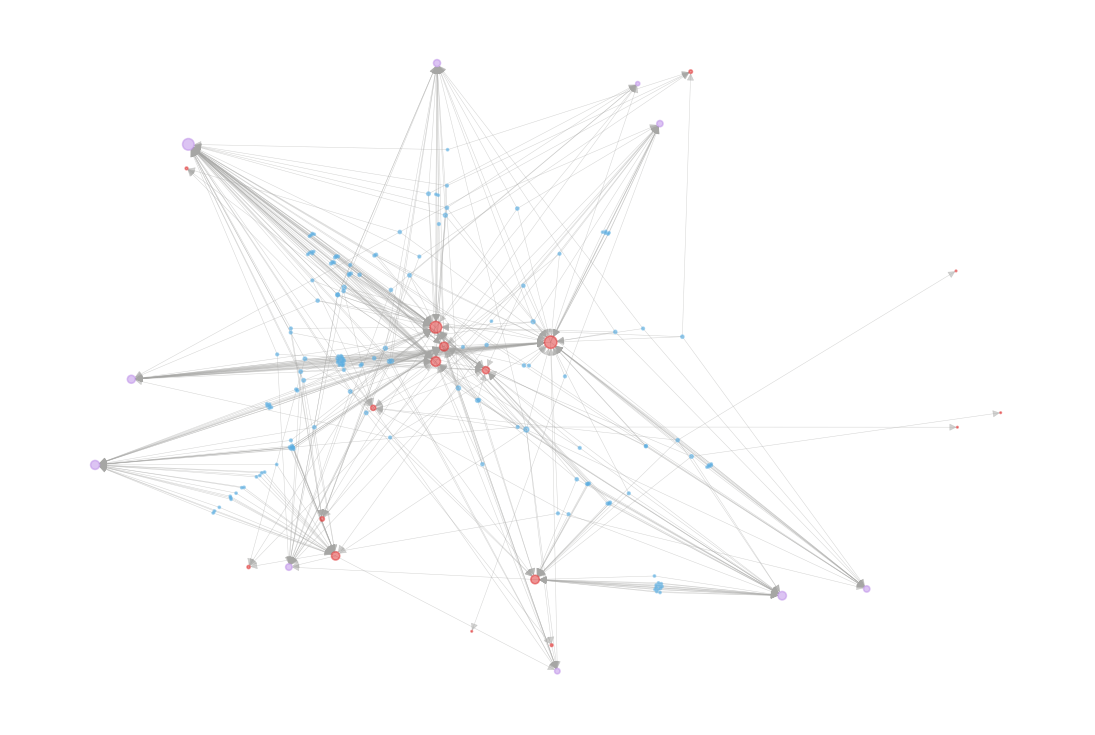

In [368]:
KeywordQuery.drawGraph()

### Querying Authors to search posible colaborations 

In [395]:
from networkx.algorithms.shortest_paths.unweighted import all_pairs_shortest_path
from networkx.algorithms.shortest_paths.generic import shortest_path


class Collaborations:
    
    def __init__(self, G, Topic):
        self.G = G
        self.Topic = Topic
    
    def filternodes(self):
        papernodes = [s for s,t in (self.G.in_edges(self.Topic)) if self.G.node[s]['type']=='PaperId']
        filternodes =[]
        for n in papernodes:
            filternodes.append(n)
            [filternodes.append(s) for s,t in (self.G.in_edges(n)) if self.G.node[s]['type']=='Authors']
        return(filternodes)

    def queryGraph(self):
        filternodes = self.filternodes()
        query = self.G.subgraph(filternodes)
        degree_dict = dict(query.degree(query.nodes()))
        nx.set_node_attributes(query, degree_dict, 'degree')
        return(query)
    
    def collabs(self):
        query = self.queryGraph()
        paths = dict(nx.all_pairs_shortest_path(query.subgraph([n for n,v in query.nodes(data=True) if v['type'] == 'Authors'])))
        PossibleCollabs = {}
        for k in paths.keys():
            for v in paths[k].values():
                if len(v)>1:
                    links = itertools.permutations([n for n in v],2)
                    for s,t in links:
                        if query.has_edge(s,t)==False:
                            PossibleCollabs[s,t] = 1
        return(PossibleCollabs)
    
    def collabGraph(self):
        PossibleCollabs = self.collabs()
        modifiedQuery = self.queryGraph().copy()
        modifiedQuery.add_edges_from([(src, trg, dict(type='POSSIBLE_COLLABORATION')) for src, trg in PossibleCollabs.keys()], edge_color='#0526e3')
        return(modifiedQuery)
    
    
    def drawGraph(self):
        modifiedQuery = self.collabGraph()
        return(nx.draw(modifiedQuery, with_labels=False, pos = nx.spring_layout(modifiedQuery),
            node_color=[color for n, color in modifiedQuery.node('node_color')],
            edge_color=[edge_color for s,t,edge_color in modifiedQuery.edges.data('edge_color')], 
            node_size=[degree for n, degree in modifiedQuery.node('degree')],
            width=0.3,
            alpha=0.5,
            font_size=5))

In [396]:
topicSample = sample([n for n,t in G.node.data() if t['type']=='Topics'],1)[0]
print(topicSample)

web-based recommendation systems : Topics


<IPython.core.display.Javascript object>


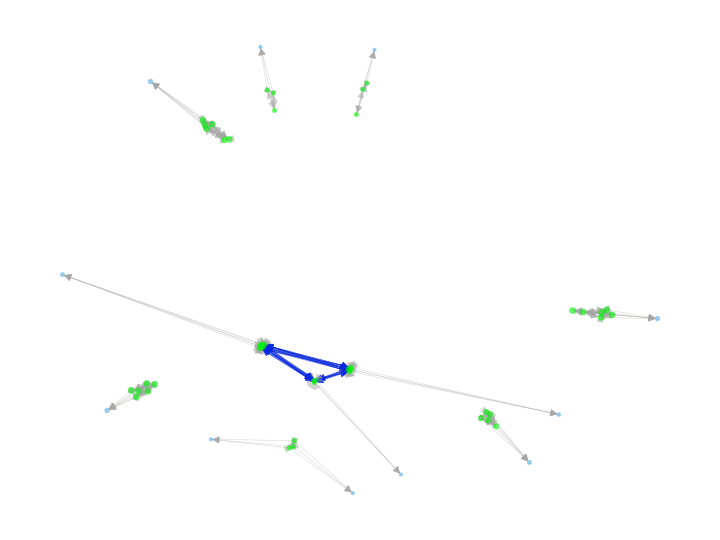

In [397]:
test = Collaborations(G, topicSample)
test.drawGraph()

In [391]:
for c in test.collabs().keys():
    print(c)

('X Zhang', 'Xiaotong Zhang')
('Xiaotong Zhang', 'X Zhang')
('S Nijssen', 'W Zhi')
('W Zhi', 'S Nijssen')
('S Nijssen', 'X Wang')
('X Wang', 'S Nijssen')
('S Nijssen', 'B Qian,\xa0P Butler')
('B Qian,\xa0P Butler', 'S Nijssen')
('S Nijssen', 'N Ramakrishnan')
('N Ramakrishnan', 'S Nijssen')
('S Nijssen', 'ZH Zhou')
('I Davidson', 'ZH Zhou')
('ZH Zhou', 'S Nijssen')
('ZH Zhou', 'I Davidson')
('S Nijssen', 'SY Li')
('I Davidson', 'SY Li')
('X Wang', 'SY Li')
('SY Li', 'S Nijssen')
('SY Li', 'I Davidson')
('SY Li', 'X Wang')
('S Nijssen', 'Y Jiang')
('I Davidson', 'Y Jiang')
('X Wang', 'Y Jiang')
('Y Jiang', 'S Nijssen')
('Y Jiang', 'I Davidson')
('Y Jiang', 'X Wang')
('Xiaotong Zhang', 'Xinyue Liu')
('Xinyue Liu', 'Xiaotong Zhang')
('B Qian,\xa0P Butler', 'ZH Zhou')
('ZH Zhou', 'B Qian,\xa0P Butler')
('B Qian,\xa0P Butler', 'S Gilpin')
('S Gilpin', 'B Qian,\xa0P Butler')
('B Qian,\xa0P Butler', 'SY Li')
('SY Li', 'B Qian,\xa0P Butler')
('B Qian,\xa0P Butler', 'Y Jiang')
('Y Jiang', 'B Qi